# Preforming Topic Modeling on Amazon Review Data 

### Contents 

- [Import Packages](#Import-Packages)
- [Import Data](#Import-Data)
- [Data Cleaning](#Data-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Data Processing](#Data-Processing)
- [LDA Modeling](#LDA-Modeling)
- [Topic Interpretation](#Topic-Interpretation)
- [Limitations](#Limitations)
- [Conclusion & Next Steps](#Conclusion-&-Recommendations)
- [Sources](#Sources) 



### Import Packages

In [50]:
import os
import json
import gzip
import csv
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib.style as style 
from matplotlib.ticker import MaxNLocator
import missingno as msno 
from urllib.request import urlopen
import regex as re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


import gensim
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim

### Import Data 

The data is broken into 2 datasets, the first is the reviews dataset with a total of 883,636 rows. There is also the metadata information which will be loaded to help which products are being reviewed. 

In [3]:
# reading in Amazon Fashion review data 
data = []
with gzip.open('./data/AMAZON_FASHION.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
    
# total length of list, this number equals total number of products
print(len(data))

# first row of the list
print(data[0])


883636
{'overall': 5.0, 'verified': True, 'reviewTime': '10 20, 2014', 'reviewerID': 'A1D4G1SNUZWQOT', 'asin': '7106116521', 'reviewerName': 'Tracy', 'reviewText': 'Exactly what I needed.', 'summary': 'perfect replacements!!', 'unixReviewTime': 1413763200}


In [4]:
# convert list into pandas DataFrame
df = pd.DataFrame.from_dict(data)
print(len(df))

883636


In [5]:
# checking everything looks okay 
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5.0,True,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200,NaN,NaN,NaN
1,2.0,True,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",1411862400,3,NaN,NaN
2,4.0,False,"08 25, 2014",A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack...,My New 'Friends' !!,1408924800,NaN,NaN,NaN
3,2.0,True,"08 24, 2014",A2UH2QQ275NV45,7106116521,Jodi Stoner,too tiny an opening,Two Stars,1408838400,NaN,NaN,NaN
4,3.0,False,"07 27, 2014",A89F3LQADZBS5,7106116521,Alexander D.,Okay,Three Stars,1406419200,NaN,NaN,NaN


In [6]:
df.shape

(883636, 12)

Next, is to read in the Metadata which contains the product information. 

In [7]:
# this dataset includes a notebook which walks you through additional data cleaning, this is pulled from that 
# https://colab.research.google.com/drive/1Zv6MARGQcrBbLHyjPVVMZVnRWsRnVMpV#scrollTo=LgWrDtZ94w89
asin_data = []
with gzip.open('./data/meta_AMAZON_FASHION.json.gz') as f:
    for l in f:
        asin_data.append(json.loads(l.strip()))
    
# total length of list, this number equals total number of products
print(len(asin_data))

# first row of the list
print(asin_data[0])

186637
{'title': 'Slime Time Fall Fest [With CDROM and Collector Cards and Neutron Balls, Incredi-Ball and Glow Stick Necklace, Paper Fram', 'image': ['https://images-na.ssl-images-amazon.com/images/I/51bSrINiWpL._US40_.jpg'], 'brand': 'Group Publishing (CO)', 'feature': ['Product Dimensions:\n                    \n8.7 x 3.6 x 11.4 inches', 'Shipping Weight:\n                    \n2.4 pounds'], 'rank': '13,052,976inClothing,Shoesamp;Jewelry(', 'date': '8.70 inches', 'asin': '0764443682'}


In [8]:
# converting the data into a DataFrame
asin_df = pd.DataFrame.from_dict(asin_data)
print(len(asin_df))

186637


In [9]:
# this dataset includes a notebook which walks you through additional data cleaning
# https://colab.research.google.com/drive/1Zv6MARGQcrBbLHyjPVVMZVnRWsRnVMpV#scrollTo=LgWrDtZ94w89
# remove rows with unformatted title (i.e. some 'title' may still contain html style content)
df3 = asin_df.fillna('')
df4 = df3[df3.title.str.contains('getTime')] # unformatted rows
product_df = df3[~df3.title.str.contains('getTime')] # filter those unformatted rows
print(len(df4))
print(len(product_df))

430
186207


In [10]:
#checking the out the first few rows 
product_df.head()

,title,image,brand,feature,rank,date,asin,description,price,also_view,also_buy,fit,details,similar_item,tech1
0,Slime Time Fall Fest [With CDROM and Collector...,[https://images-na.ssl-images-amazon.com/image...,Group Publishing (CO),[Product Dimensions:\n \n8....,"13,052,976inClothing,Shoesamp;Jewelry(",8.70 inches,0764443682,,,,,,,,
1,XCC Qi promise new spider snake preparing men'...,[https://images-na.ssl-images-amazon.com/image...,,,"11,654,581inClothing,Shoesamp;Jewelry(",5 star,1291691480,,,,,,,,
2,Magical Things I Really Do Do Too!,[https://images-na.ssl-images-amazon.com/image...,Christopher Manos,[Package Dimensions:\n \n8....,"19,308,073inClothing,ShoesJewelry(",5 star,1940280001,[For the professional or amateur magician. Ro...,,,,,,,
3,"Ashes to Ashes, Oranges to Oranges",[https://images-na.ssl-images-amazon.com/image...,Flickerlamp Publishing,[Package Dimensions:\n \n8....,"19,734,184inClothing,ShoesJewelry(",5 star,1940735033,,,,,,,,
4,Aether & Empire #1 - 2016 First Printing Comic...,[https://images-na.ssl-images-amazon.com/image...,,[Package Dimensions:\n \n10...,"10,558,646inClothing,Shoesamp;Jewelry(",5 star,1940967805,,$4.50,,,,,,


In [11]:
product_df.shape

(186207, 15)

### Data Cleaning

We'll begin by cleaning our reviews data. We'll start by checking for any missing data. 

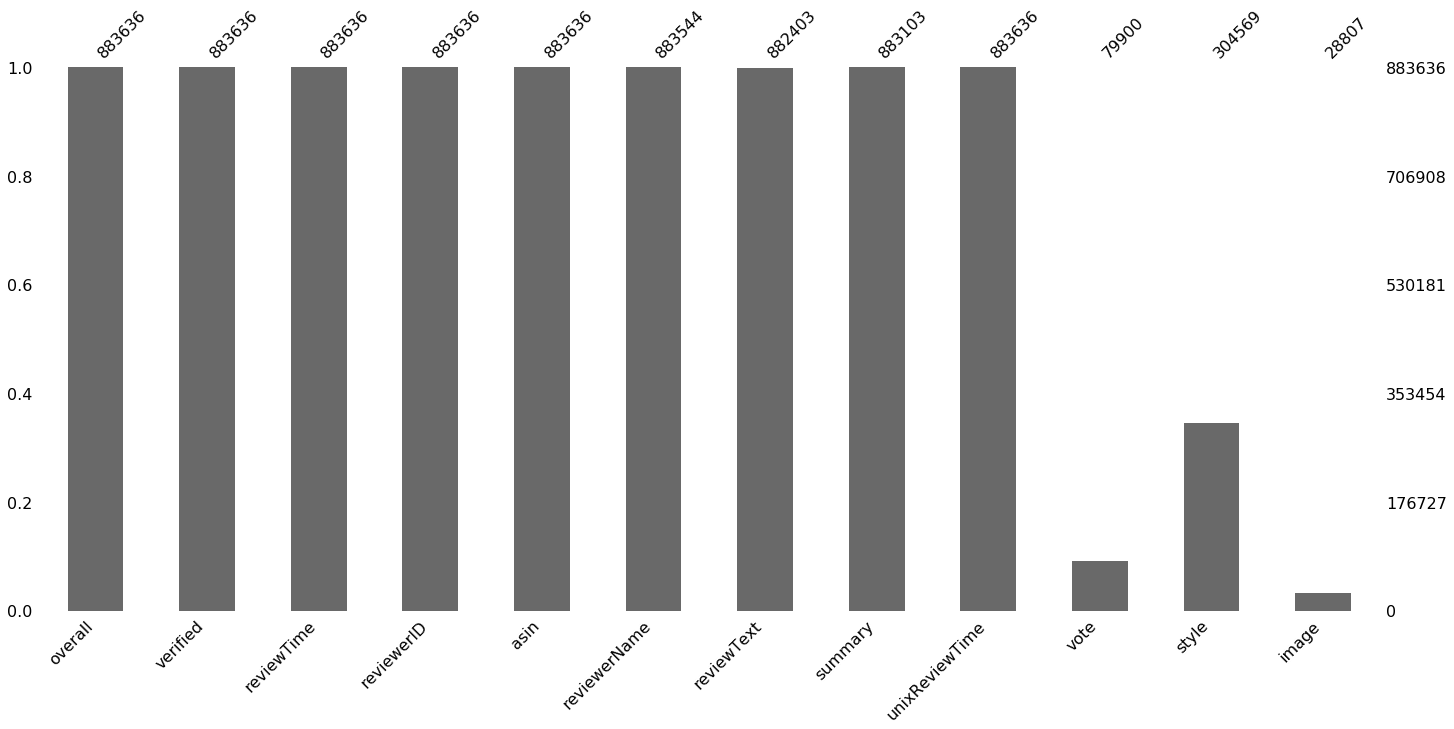

In [6]:
#plot nulls quickly 
msno.bar(df) 

In [7]:
df.isnull().sum()

overall                0
verified               0
reviewTime             0
reviewerID             0
asin                   0
reviewerName          92
reviewText          1233
summary              533
unixReviewTime         0
vote              803736
style             579067
image             854829
dtype: int64

**Observation:** There appears to be a large amount of missing data in the `vote`, `style`, and `image` columns, so we'll drop those. It also makes sense to drop the `reviewerName` column since it is a redundancy of the `reviewerID` column. To decrease the size of the DataFrame, we'll also drop the `overall`, `verified`, and the `reviewTime`& `unixReviewTime` columns, since the focus of our work will be on the `reviewText` column.  We  will also drop any rows that are missing the `reviewText`  column, as that is what we will be using to create our corpus.


In [8]:
# dropping extra columns 
df.drop(columns = ['vote', 'style', 'image',
                   'summary', 'reviewerName', 'overall',
                   'verified', 'reviewTime', 'unixReviewTime'],
                    inplace = True)

In [9]:
# dropping rows with missing data 
df.dropna( axis = 0 , subset = ['reviewText'], inplace = True)

In [10]:
# new shape? 
df.shape

(882403, 3)

In [11]:
# call .head()
df.head()

,reviewerID,asin,reviewText
0,A1D4G1SNUZWQOT,7106116521,Exactly what I needed.
1,A3DDWDH9PX2YX2,7106116521,"I agree with the other review, the opening is ..."
2,A2MWC41EW7XL15,7106116521,Love these... I am going to order another pack...
3,A2UH2QQ275NV45,7106116521,too tiny an opening
4,A89F3LQADZBS5,7106116521,Okay


In [12]:
# call .info()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 882403 entries, 0 to 883635
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   reviewerID  882403 non-null  object
 1   asin        882403 non-null  object
 2   reviewText  882403 non-null  object
dtypes: object(3)
memory usage: 26.9+ MB


**Observation:** From above, we can see that the `reviewerID` and `asin` are stored as objects. Let's convert those data types to ones we'll be able to feed into a model. 

In [13]:
# using hash to update reviewerID column. found help on how to do this on stackoverflow. 
# https://stackoverflow.com/questions/56579642/convert-unique-string-ids-to-unique-integer-ids-in-python
df['int_reviewerID'] = [hash(uid) for uid in df['reviewerID']]
# also updating the asin column to int with the hash 
df['int_asin'] = [hash(uasin) for uasin in df['asin']]

In [14]:
# Checking out the results 
df.head()

,reviewerID,asin,reviewText,int_reviewerID,int_asin
0,A1D4G1SNUZWQOT,7106116521,Exactly what I needed.,3542781409366088212,-1023968847620261250
1,A3DDWDH9PX2YX2,7106116521,"I agree with the other review, the opening is ...",7794126572371518754,-1023968847620261250
2,A2MWC41EW7XL15,7106116521,Love these... I am going to order another pack...,6502180075840563236,-1023968847620261250
3,A2UH2QQ275NV45,7106116521,too tiny an opening,2230153209942701343,-1023968847620261250
4,A89F3LQADZBS5,7106116521,Okay,-5388597961924995754,-1023968847620261250


**Observation:** Since the `asin` can be used to reference which items it represents in the `product_df`, we'll keep the old columns. From here, let's look closer at the `asin` column, as it will be used as the y in our train-test split to ensure that we are able to stratify the different products being reviewed. In order to do that though, we will need to drop any `asin` that only appear once, as y inputs need to have a population of more than one. 

In [15]:
# using group by and then .filter to remove and asin 
df = df.groupby('asin').filter(lambda x : len(x)>1)

In [16]:
# what is the new shape? 
df.shape

(782414, 5)

### Exploratory Data Analysis 

Next, we'll do some EDA to find out more about the reviews dataset. 

In [17]:
df['int_reviewerID'].value_counts()

-8038823495558440352    35
 7592335489524018495    32
-634628144775687889     30
 5395229027246828509    27
-3011778053254539134    26
                        ..
 8078639246789624787     1
-8406467454373992236     1
-4828137268045064293     1
 6938499401865350619     1
 5554198708797292235     1
Name: int_reviewerID, Length: 669500, dtype: int64

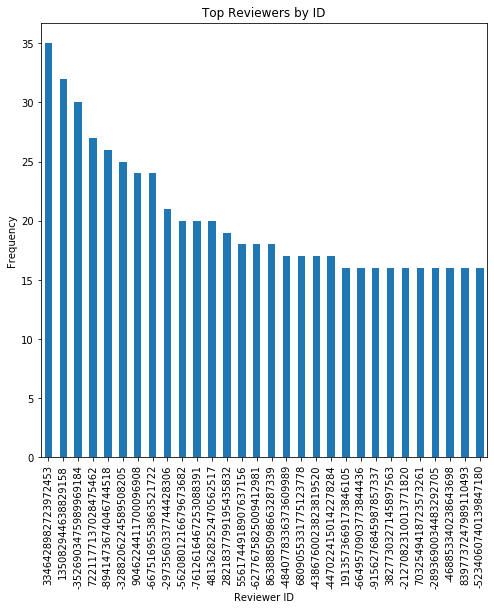

In [24]:
plt.figure(figsize = (8, 8))
plt.title("Top Reviewers by ID")
plt.xlabel('Reviewer ID')
plt.xticks(rotation= 90)
plt.ylabel('Frequency')
df['int_reviewerID'].value_counts()[:30].plot(kind = 'bar');

**Observation:** The customer who left the most reviews left 35 reviews, the majority of reviewers only left a single review. 

In [25]:
df['asin'].value_counts()

Series([], Name: asin, dtype: int64)

In [26]:
what_is_its = (product_df['asin'] == 'B000P0X15G')
product_df[what_is_its]

,title,image,brand,feature,rank,date,asin,description,price,also_view,also_buy,fit,details,similar_item,tech1
3315,"i play. Girls' Baby Brim Sun Protection Hat, A...",[https://images-na.ssl-images-amazon.com/image...,i play.,[Shipping Information:\n \n...,,5 star5 star (0%),B000P0X15G,,$7.99 - $18.38,,,"class=""a-normal a-align-center a-spacing-smal...",,,


Using the `asin` and the Product DataFrame, these are the 20 items with the most reviews. 

|`asin` |Number of Reviews| Product Name / title|
|---|---|---|
|B000V0IBDM| 4380 |Powerstep Pinnacle Orthotic Shoe Insoles|
|B000KPIHQ4|4371 |Powerstep Pinnacle Orthotic Shoe Insoles |
|B00I0VHS10|3884|90 Degree By Reflex Power Flex Yoga Capri | 
|B00RLSCLJM|3633|MJ Metals Jewelry 2mm to 10mm White Tungsten Carbide Mirror Polished Classic Wedding Ring | 
|B000PHANNM|2566 |i play. Baby Boys Flap Sun Protection Hat|
|B000YFSR5G|2534 |Hanes Mens EcoSmart Fleece Sweatpant|
|B00201ER88|2202|i play. by green sprouts Baby & Toddler Brim Sun Protection Hat |
|B00GXE331K|2025|Best RFID Blocking Card Holder Case for Men|
|B000P0X15G|1924|i play. Girls' Baby Brim Sun Protection Hat|
|B00XT15P8E|1855|Marino Avenue Men’s Genuine Leather Ratchet Dress Belt|
|B0017U1KBK|1826|Totes Kids Bubble Umbrella|
|B005N7YWX6|1688|Ingrid & Isabel Women's Maternity Everyday Bellaband|
|B004HX6P1E|1671|BodyJ4You 50PC Tongue Barbells Nipple Rings 14G Mix Acrylic Ball Steel Flexible Piercing Jewelry|
|B000YFSR4W|1648|Hanes Mens EcoSmart Fleece Sweatpant|
|B009RUKQ2G|1590|Scarleton Large Satchel H106801 - Black|
|B000JOOR7O|1584|Vans Adult Classic Slip-On, (Checkerboard)|
|B00ZW3SCF0|1522|Womens Crop Top Midi Skirt Outfit Two Piece Bodycon Bandage Dress|
|B000GHRZN2|1415|Carhartt Men's Loose Fit Five Pocket Canvas Carpenter Jean|
|B000GHMRLW|1415|Carhartt Men's Loose Fit Five Pocket CanvasCarpenter Jean|
|B00XTM0ZPG|1405|WearMe Pro - Classic Half Frame Polarized Sunglasses|

From examining the most frequently occuring `asin` we can see there is both Men's, Women's and Children's clothing products listed under the umbrella of Amazon Fashion. The dataset also includes items that are a little more broad, including shoe insoles, accessories, etc but still within the ready-to-wear category. 

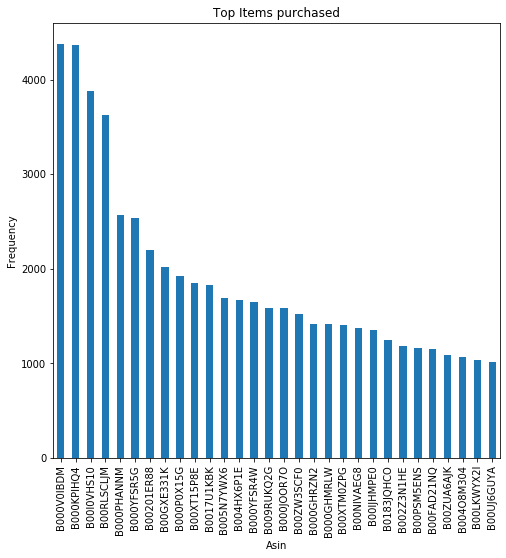

In [27]:
plt.figure(figsize = (8, 8))
plt.title("Top Items purchased")
plt.xlabel('Asin')
plt.xticks(rotation= 90)
plt.ylabel('Frequency')
df['asin'].value_counts()[:30].plot(kind = 'bar');

### Data Processing 

From here let's move into processing the `ReviewText` column to prep for modeling. We'll begin by lowercasing the text, then we'll expand any contractions, and then remove any non-letters. 

In [18]:
# We'll begin by lowercasing the reveiwText column
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['reviewText'].head()

0                               exactly what i needed.
1    i agree with the other review, the opening is ...
2    love these... i am going to order another pack...
3                                  too tiny an opening
4                                                 okay
Name: reviewText, dtype: object

In [19]:
# Next, we'll work on expanding the contradictions 
# I used this article on stack over flow for help with expanding contractions, which is where this edited list is from. 
# https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions_dict = { 
        "ain't": "am not ",
        "aren't": "are not / am not",
        "can't": "cannot",
        "can't've": "cannot have",
        "'cause": "because",
        "could've": "could have",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he would", 
        "he'll": "he will",
        "he's": " he is",
        "how'd": "how did",
        "how'll": "how will",
        "how's": "how is ",
        "I'd": "I would",
        "I'll": "I will",
        "I'm": "I am",
        "I've": "I have",
        "isn't": "is not",
        "it'd": "it would",
        "it'll": " it will",
        "it's": "it has / it is",
        "let's": "let us",
        "ma'am": "madam",
        "might've": "might have",
        "mightn't": "might not",
        "must've": "must have",
        "mustn't": "must not",
        "needn't": "need not",
        "o'clock": "of the clock",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "she'd": "she would",
        "she'd've": "she would have",
        "she'll": "she will",
        "she's": "she is",
        "should've": "should have",
        "shouldn't": "should not",
        "so've": "so have",
        "so's": "so is",
        "that'd": "that would",
        "that's": "that is",
        "there'd": "there would",
        "there's": "there is",
        "they'd": "they would",
        "they'll": "they will",
        "they're": "they are",
        "they've": "they have",
        "wasn't": "was not",
        "we'd": "we would",
        "we'll": "we will",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what will",
        "what're": "what are",
        "what's": "what is",
        "what've": "what have",
        "when's": "when is",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where is",
        "where've": "where have",
        "who'll": "who will",
        "who's": " who is",
        "who've": "who have",
        "why's": "why is",
        "why've": "why have",
        "will've": "will have",
        "won't": "will not",
        "would've": "would have",
        "wouldn't": "would not",
        "y'all": "you all",
        "y'all'd": "you all would",
        "y'all're": "you all are",
        "y'all've": "you all have",
        "you'd": "you would",
        "you'd've": "you would have",
        "you'll": "you will",
        "you're": "you are",
        "you've": "you have",
}
contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

In [20]:
# creating functions to replace the contractions found with their expansion.
def replace(match): 
    return contractions_dict[match.group(0)]\

def expand_contractions(s , contractions_dict=contractions_dict):
    return contractions_re.sub(replace, s)

In [21]:
# apply function to the reviewText column
df['reviewText'] = [expand_contractions(s, contractions_dict=contractions_dict) for s in df['reviewText']]
df['reviewText'].head()

0                               exactly what i needed.
1    i agree with the other review, the opening is ...
2    love these... i am going to order another pack...
3                                  too tiny an opening
4                                                 okay
Name: reviewText, dtype: object

In [22]:
# Finally, we'll remove any non-letters
df['reviewText'] =df['reviewText'].str.replace('[^\w\s]','')
df['reviewText'].head()

<>:2: DeprecationWarning: invalid escape sequence \w
<>:2: DeprecationWarning: invalid escape sequence \w
<>:2: DeprecationWarning: invalid escape sequence \w
<ipython-input-22-14d930c105d3>:2: DeprecationWarning: invalid escape sequence \w
  df['reviewText'] =df['reviewText'].str.replace('[^\w\s]','')


0                                exactly what i needed
1    i agree with the other review the opening is t...
2    love these i am going to order another pack to...
3                                  too tiny an opening
4                                                 okay
Name: reviewText, dtype: object

Now we will take our values to list, then tokenize them, remove any numbers and any words that are only one character long. And for now, what we do for training we'll do for our testing values as well. 

In [23]:
data = df['reviewText'].values.tolist()

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(data)):
    data[idx] = tokenizer.tokenize(data[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
data = [[token for token in doc if not token.isnumeric()] for doc in data]

# Remove words that are only one character.
data = [[token for token in doc if len(token) > 1] for doc in data]
print(data[:1])

[['exactly', 'what', 'needed']]


In [24]:
# Next, we'll remove stopwords
# first instanite english stopwords
stop_words = stopwords.words('english')
# Then remove stopwords
data = [[word for word in text if word not in stop_words] for text in data]

Next up is lemmatizing the data. According to the Gensim documentation, lemmatization is prefered over stemming because topic modeling is best preformed on readable words. 

In [25]:
# Lemmatize the documents.
lemmatizer = WordNetLemmatizer()
data = [[lemmatizer.lemmatize(token) for token in text] for text in data]

Next up is to create bigrams and add then to our data. 

In [26]:
# Compute bigrams.
# Add bigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(data, min_count=20)
for text in range(len(data)):
    for token in bigram[data[text]]:
        if '_' in token:
            # Token is a bigram, add to document.
            data[text].append(token)

In [27]:
df['reviewText_processed'] = data

In [28]:
df.head()

,reviewerID,asin,reviewText,int_reviewerID,int_asin,reviewText_processed
0,A1D4G1SNUZWQOT,7106116521,exactly what i needed,3542781409366088212,-1023968847620261250,"[exactly, needed]"
1,A3DDWDH9PX2YX2,7106116521,i agree with the other review the opening is t...,7794126572371518754,-1023968847620261250,"[agree, review, opening, small, almost, bent, ..."
2,A2MWC41EW7XL15,7106116521,love these i am going to order another pack to...,6502180075840563236,-1023968847620261250,"[love, going, order, another, pack, keep, work..."
3,A2UH2QQ275NV45,7106116521,too tiny an opening,2230153209942701343,-1023968847620261250,"[tiny, opening]"
4,A89F3LQADZBS5,7106116521,okay,-5388597961924995754,-1023968847620261250,[okay]


In [39]:
#writing out the processed DF to work on clustering in another notebook. 
df.to_csv('./data/processed_data.csv', index=False)

At this point it makes sense to do our train test split as we've fully processed the `reviewText` column for LDA modeling. 

In [35]:
# defining our X and Y variables, we won't be using our Y variables, as it's an unsupervised model. 
X = df[['reviewText','reviewText_processed', 'int_asin', 'int_reviewerID']]
y = df['asin']  # I'm using the asin as my Y value so I can stratify my train/test split on it. 

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size =.70, random_state = 42, stratify = y)

In [67]:
lda_train = X_train['reviewText_processed'].values.tolist()
lda_train[:1]

[['fit', 'grandson', 'perfectly', 'mths', 'old', 'small', 'mths', 'size']]

In [68]:
lda_test = X_test['reviewText_processed'].values.tolist()
lda_test[:1]

[['purse',
  'exactly',
  'hoping',
  'sturdy',
  'great',
  'zipper',
  'feel',
  'like',
  'real',
  'leather',
  'great',
  'value',
  'price',
  'paid',
  'much',
  'purse',
  'satisfied',
  'would',
  'definitely',
  'recommend',
  'anyone',
  'looking',
  'stylish',
  'sturdy',
  'affordable',
  'purse',
  'real_leather',
  'definitely_recommend']]

In [69]:
print('Training Documents: %d' % len(lda_train))
print('Testing Documents: %d' % len(lda_test))

Training Documents: 547689
Testing Documents: 234725


From here, we're going to use the training data to create a dictionary and do one last bit of cleaning to remove any outliers or words that occur too freqently. Then we'll create our corpus  to be use to train our model on. 

In [73]:
# Create a dictionary representation of the documents.
dictionary = Dictionary(lda_train)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

In [74]:
# creating our corpus or our bag of words for the data. 
corpus = [dictionary.doc2bow(text) for text in lda_train]

pickle.dump(corpus, open('./data/corpus.pkl', 'wb'))
dictionary.save('./data/dictionary.gensim')

In [75]:
# Checking out how many tokens we have and how many documents. 
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))


Number of unique tokens: 11478
Number of documents: 547689


In [52]:
corpus[0]

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]

### LDA Modeling 

From here we'll begin our topic modeling. As previously mentioned, we'll be using the Gensim Python library to do our modeling. We'll begin by finding the $c_{v}$ coherence score and preplexity score for a range of topic numbers to find which number of topics makes the most sense based on the scores. 

In [53]:
# For this section of the project I got help from the book Natural Language Processing Fundamentals (Ghosh & Gunning)
# creating function to calculate cohenerence of the models 
def calculate_coherence_score(documents, dictionary, model): 
    coherence_model = CoherenceModel(model = model,          # all provided when calling the function
                                    texts = documents, 
                                    dictionary = dictionary, 
                                    coherence = 'c_v')      # using 'c_v' as my coherence score it's measured between 0-1
    return coherence_model.get_coherence()

# then we'll create another function to find coherence scores for a range of topic numbers 
def get_coherence_values(start, stop): 
    for num_topics in range(start, stop):
        print(f'\nCalculating coherence for {num_topics} topics')
        # here is where we're instatiating this LDA model, using the corpus we created with the training data
        ldamodel = LdaModel(corpus,                   # training data    
                            num_topics = num_topics,  # looping through set number of topics 
                            id2word= dictionary,      # words in training data
                            chunksize = 20_000,       # number of documents processed at a time, quite high to reduce training time
                            passes = 8,              # passes = epochs, lower to speed up results
                            eval_every = None)        # this is time intensive, so turning off 
        coherence = calculate_coherence_score(lda_train,   # calling the calculate_coherence_score with the data and dictionary we've created
                                              dictionary, 
                                              ldamodel)
        print('\nPerplexity:', ldamodel.log_perplexity(corpus)) # print out the preplexity score of each model
        yield coherence   # yeilding that topic number's coherence and looping back through till we finish the range

In [54]:
# setting topic mins and maxs
min_topics, max_topics = 5, 15
# finding the coherence scores for our topics range. 
coherence_scores= list(get_coherence_values(min_topics, max_topics))


Calculating coherence for 5 topics

Perplexity: -7.086162663421977

Calculating coherence for 6 topics

Perplexity: -7.084259156792643

Calculating coherence for 7 topics

Perplexity: -7.090258215415431

Calculating coherence for 8 topics

Perplexity: -7.09581667444592

Calculating coherence for 9 topics

Perplexity: -7.115370335915739

Calculating coherence for 10 topics

Perplexity: -7.158175081257228

Calculating coherence for 11 topics

Perplexity: -7.1961967545746415

Calculating coherence for 12 topics

Perplexity: -7.2090458108949464

Calculating coherence for 13 topics

Perplexity: -7.226585557426354

Calculating coherence for 14 topics

Perplexity: -7.2317192107903425


Now that we've calculated the coherence $c_{v}$ score and perplexity scores let's dicuss what those metrics actually mean. According to Sayed and Spruit(2017) the coherence $c_{v}$ is based on four parts: 
1. segementation of the data into word pairs
2. calculation of word or word pair proababilities 
3. calculation of a confirmation measure that quantifies how strongly a word set supports another word set
4. Finally, aggregation of individual confirmation measures into an overall coherence score.  

Coherence $c_{v}$ scores are measured from 0-1. 

As for perplexity, it is a measure of how well a probability model predicts a sample. The formula for evaluating testing data is: 
$per(D_{test})=exp\{-\frac{\sum_{d=1}^{M}\log p(\mathbb{w}_d)}{\sum_{d=1}^{M}N_d}\}$

A lower preplexity score indicates better generalized performace. Perplexity is inversley related to the log-likelihood. Thus, higher the log-likelihood, lower the perplexity. This is the metric we will focus on to judge the models performance on our testing data. 



Text(0.5, 1.0, 'Coherence Scores')

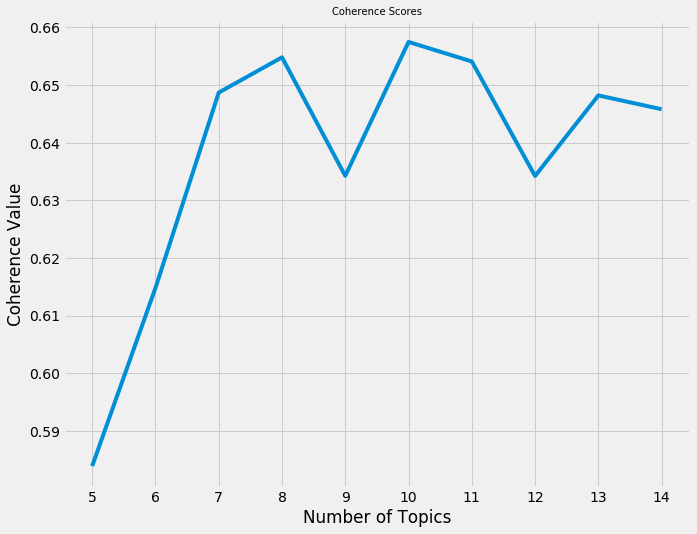

In [56]:
# Again, I got help from this section from the book Natural Language Processing Fundamentals (Ghosh & Gunning)
# Setting plot style and figsize 

style.use('fivethirtyeight')
ax = plt.figure(figsize =(10, 8))

# creating the x values, the number of topics 
x = [int(i) for i in range(min_topics, max_topics)]

# plotting our x and coherence_scores 
plt.plot(x, coherence_scores)
plt.xticks(x)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Value')
plt.title('Coherence Scores', fontsize = 10)

From the graph we can see our highest coherence score was at 10 topics. We'll now run that model to interpret the different topics. 

In [61]:
# Creating the working LDA model with correct number of topics. 
ldamodel = LdaModel(corpus,          
                    num_topics = 10,
                    id2word= dictionary,
                    chunksize= 20_000,
                    alpha='auto',         # auto-tuning Alpha parameter
                    eta='auto',           # auto-tuning Eta parameter 
                    passes = 20,
                    eval_every = None )
# saving model 
ldamodel.save('model.gensim')

We'll find the coherence and perplexity score for our training model. 

In [65]:
coherence_model_lda = CoherenceModel(model=ldamodel, texts=lda_train, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
coherence_lda  

/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/gensim/topic_coherence/text_analysis.py:449: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn("stats accumulation interrupted; <= %d documents processed", self._num_docs)


0.6594434321524035

In [67]:
print('\nPerplexity:', ldamodel.log_perplexity(ldamodel))


Perplexity: -7.089086219735926


Now, we'll find the scores for the testing data. First, we just need to create the corpus for the testing data. 

In [85]:
other_corpus = [dictionary.doc2bow(text) for text in lda_test]

pickle.dump(corpus, open('./data/other_corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')


In [90]:
# Compute Perplexity
print('\nTesting Perplexity: ', lda.log_perplexity(other_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda, texts=lda_test, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nTesting Coherence Score: ', coherence_lda)


Perplexity:  -7.104853018662892

Coherence Score:  0.6636613799197868


Our model actually performed better on the testing data then the training data, I believe this is due to the imbalance in the number of documents trained on vs. the number tested on. 

Next, we'll retrive the topic vectors. 

In [76]:
# creating for look to find the topic vectors for each input
train_vecs = []
for i in range(len(lda_train)):
    top_topics = lda.get_document_topics(corpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(10)]
    train_vecs.append(topic_vec)

In [77]:
# how many vectors? 
len(train_vecs)

547689

In [78]:
# checking out the first vector. 
train_vecs[0]

[0.04536262,
 0.021848572,
 0.02352208,
 0.015930317,
 0.017118761,
 0.09425244,
 0.24352369,
 0.19526112,
 0.32740048,
 0.015779905]

In [103]:
# writing this data to CSV 
with open('./data/train_vecs.csv','w') as train_vec:
    wr = csv.writer(train_vec, dialect='excel')
    wr.writerow(train_vecs)

### Topic Interpretation

From there we'll use the pyLDAvis tool to look at the different topics. 

In [91]:
lda = LdaModel.load('model.gensim')

In [ ]:
corpus = 

In [92]:
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary)

In [93]:
pyLDAvis.display(lda_display)

As we can see from the visual on the left there is a good amount of overlap on a few of the topics created. In all the iterations of modeling this one has the closest distance between topics. Topics 1, 2, 3, and 4 are more closely related as well as 7 and 9 which also have some overlap. The  On the right are the Top 30 most useful terms in interpreting the topic. According the research done by the creators of the LDAvis method of visualizing and interpreting Topics, the ideal $\lambda $ for interpreting the topics is 0.6 (Sievert & Shirley, 2014) From here let's figure out what our topics mean. 

|Topic|Observations|
|---|---|
|Topic 1| Our first topic does not seem to have a clear theme, Most salient words are: one, get and time.   | 
|Topic 2| Topic 2 main theme is satisfaction, with the most salient terms being love, great and good. | 
|Topic 3| This topic grouping seems to have themes of people not purchasing items in the correct size. | 
|Topic 4| This topic is dissatisfaction, with words like: cheap, material, thin, and bad|
|Topic 5|  With words like leggings, bra. This topic represent Women's Clothing| 
|Topic 6| The underlying theme of this topic seems to be Jewelry and Accessories|
|Topic 7| This topic seems to represent wallets, handbags, and other related small accessories like phone cases|
|Topic 8| The theme of this topic is footwear| 
|Topic 9| The topic looks like yet another segmentation of seasonal accessories with mentions of both gloves and sun. | 
|Topic 10| Our final topic represents gifting| 

### Limitations 


There are a few limitations we should consider when it come to this model. First, the model was trained specifically on the data from the Amazon Fashion dataset, it will not perform as well on any other product group on Amazon. You would need to re-train the model for each different product group, as the words and topics in the reviews will be different.

LDA modeling works by creating topics based off the frequency of their appearance within the corpus, which explain why we got a few cluster that mostly represented customers emotions, like satisfaction and dissatisfaction. 

### Conclusion and Next Steps 

Using LDA modeling we were able to find the ideal number of topics for our dataset was 10. We then built our working model which had the following results: 

|Metric| Training Score| Testing Score| 
|---|---|---|
|Coherence $c_{v}$|0.659 | 0.663|
|Perplexity|-7.089 | -7.104| 

Our testing data actually performed slightly better than the training data. After examining the 10 topics created by the model it was pretty easy to identify what most of the topics were about, but not all of them were useful for segmenting types of products purchased, they also represented the customer's feelings about the products which makes sense because they are leaving reviews. The product groups that are represented in the topics are: women's clothing, jewelry, small accessories/ handbags, footwear, seasonal accessories, and gifting. These are all categories that would translate well to suggestion through a e-mailed marketing campaign. 

All data is prepped and processed to do additional modeling with the result from the LDA topic modeling. From here, it would be cool to build a classification model to try and predict what topic a review might fall under. These outputs could also be used along with the reviewer and product information to create customer segmentations. 




### Sources 

Justifying recommendations using distantly-labeled reviews and fined-grained aspects
Jianmo Ni, Jiacheng Li, Julian McAuley
Empirical Methods in Natural Language Processing (EMNLP), 2019

https://colab.research.google.com/drive/1Zv6MARGQcrBbLHyjPVVMZVnRWsRnVMpV#scrollTo=LgWrDtZ94w89

https://stylecaster.com/amazon-fashion-the-drop-by-you-february-2020/ Bella Gerard 

https://www.latimes.com/entertainment-arts/business/story/2020-02-22/amazon-making-the-cut-reality-tv-heidi-klum-prime
Wendy Lee, Feb 22 2020

https://github.com/marcotav/unsupervised-learning/tree/master/topic-modeling

https://books.google.com/books?id=i8-PDwAAQBAJ&pg=PA164&lpg=PA164&dq=using+nlp+data+and+also+customer+ids+for+clustering&source=bl&ots=J8auw-oehF&sig=ACfU3U3RKK_rHPXi0dH6bQ-le4A9BXSUFw&hl=en&ppis=_c&sa=X&ved=2ahUKEwjg7fLK0ojoAhUtj3IEHSorC7gQ6AEwCXoECA8QAQ#v=onepage&q&f=false


https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

https://towardsdatascience.com/unsupervised-nlp-topic-models-as-a-supervised-learning-input-cf8ee9e5cf28

Proceedings of the Workshop on Interactive Language Learning, Visualization, and Interfaces, pages 63–70,
Baltimore, Maryland, USA, June 27, 2014. c 2014 Association for Computational Linguistics https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf